**Introduction**

The Dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The goal is then to predict which previously purchased products will be in a user’s next order. Now let's jump straight into the data and do some exploratory analysis.

# Importing ncessary libraries

In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reading all the files

In [ ]:
#reading all files
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

# Products
Let's take time & explore products data. We have two datasets from files:
* order_products__prior.csv : contains historical details of order-product level.(Around 1M records)
* order_products_train.csv : contains recent order details of customer's order-products.(Around 32M records)

**Observation Summary:**
- We have **3346083 orders & 49685 unique products**.
- on an average, people order **5-6 products** everytime.
- Roughly **59% people tend to reorder**.

In [ ]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [ ]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [ ]:
order_products = pd.concat([order_products_prior, order_products_train],axis=0)
order_products.shape

(33819106, 4)

In [ ]:
order_products.isna().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0


Looks like there is no missing data in this dataset.

In [ ]:
print(f'In this dataset there are {order_products.order_id.nunique()} orders & {order_products.product_id.nunique()} unique products.')

In this dataset there are 3346083 orders & 49685 unique products.


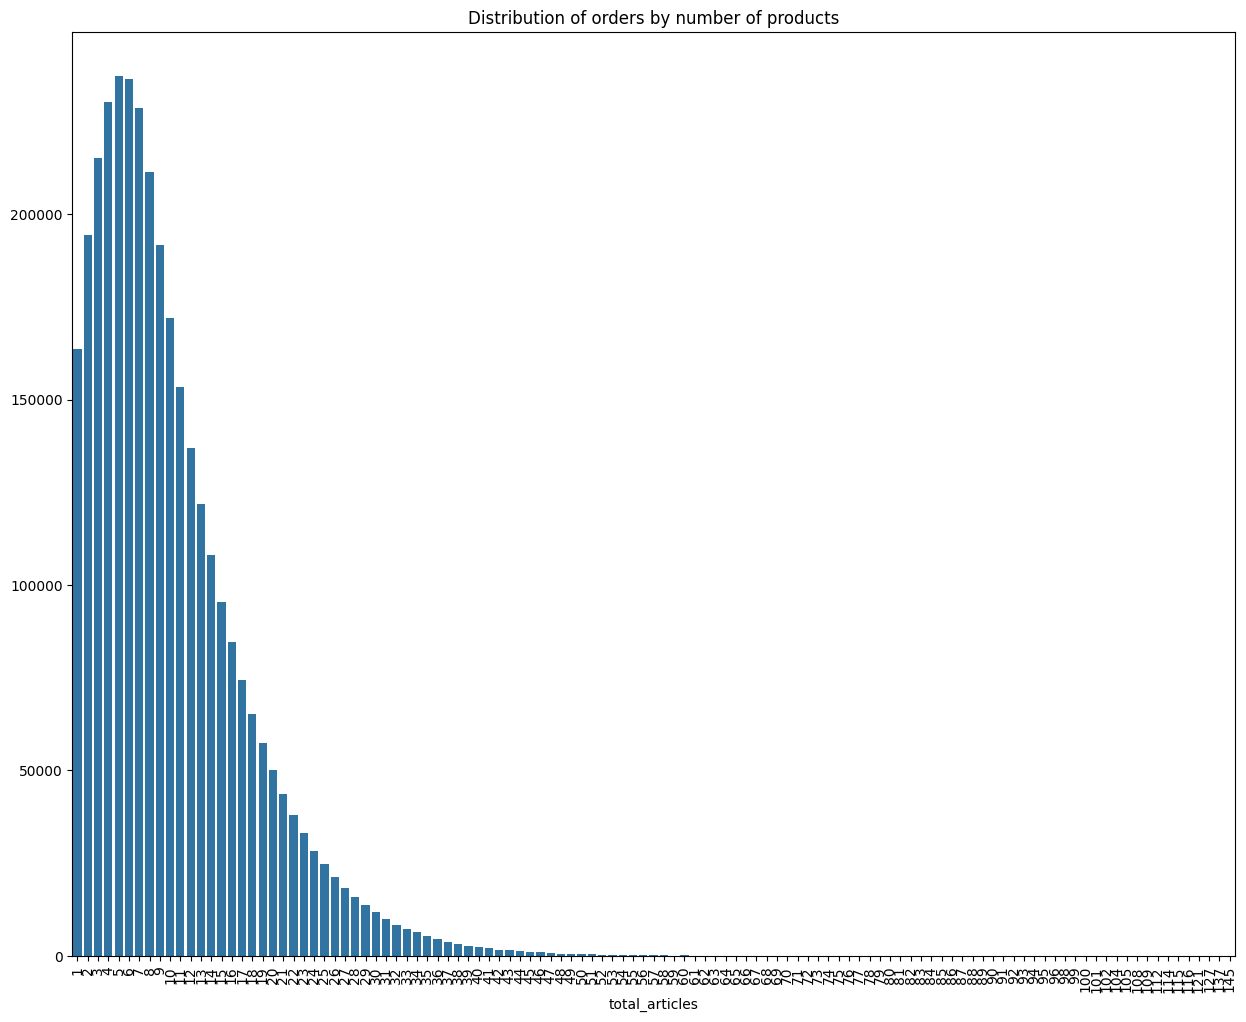

In [ ]:
# finding maximum products per order
max_product = order_products.groupby('order_id').agg(
    total_articles = ('product_id','count')
)
# calculating number of orders for each max product to see distribution by number of artcles
max_product_distribution = max_product.total_articles.value_counts()

#plotting
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='vertical')
sns.barplot(x=max_product_distribution.index, y=max_product_distribution.values, ax=ax)
plt.title('Distribution of orders by number of products')
plt.show()

So on an average, people order **5-6 products** everytime.

**Which are most Ordered products?**

In [ ]:
top_ten_products = order_products.groupby('product_id').agg(
    total_orders = ('order_id','count')
).sort_values(by='total_orders',ascending=False).head(10)

top_ten_products = pd.merge(top_ten_products,products[['product_id','product_name']],on='product_id')
top_ten_products

,product_id,total_orders,product_name
0,24852,491291,Banana
1,13176,394930,Bag of Organic Bananas
2,21137,275577,Organic Strawberries
3,21903,251705,Organic Baby Spinach
4,47209,220877,Organic Hass Avocado
5,47766,184224,Organic Avocado
6,47626,160792,Large Lemon
7,16797,149445,Strawberries
8,26209,146660,Limes
9,27845,142813,Organic Whole Milk


**Are reordered products dominant or fresh purchases?**

In [ ]:
df = order_products.groupby('reordered').agg(
    reordered_product_count = ('product_id','count')
).reset_index()
df['ratio'] = df.reordered_product_count/df.reordered_product_count.sum()
df

,reordered,reordered_product_count,ratio
0,0,13863746,0.409938
1,1,19955360,0.590062


Around **59% people tend to reorder**.

# Orders Exploration

This dataset contains relation between orders & user id along with other order specifications like day of week, hour of day, & days since old order.

**Summary of observation:**
- *6% of data is missing* for **days_since_prior_order** feature.
- The active hours are roughly between **7am-7pm**.
- Considering standard day of the week codes, there seems to be more orders **Monday & Tuesday**.

In [ ]:
missing_perc = orders.isna().sum()
missing_perc = missing_perc/orders.shape[0]
missing_perc

,0
order_id,0.000000
user_id,0.000000
eval_set,0.000000
order_number,0.000000
order_dow,0.000000
order_hour_of_day,0.000000
days_since_prior_order,0.060276


Close to *6% data is missing* for **days_since_prior_order** column. This can be removed in data cleaning step

**Time of orders**

When most of the orders are placed during the day.

<Axes: xlabel='order_hour_of_day', ylabel='count'>

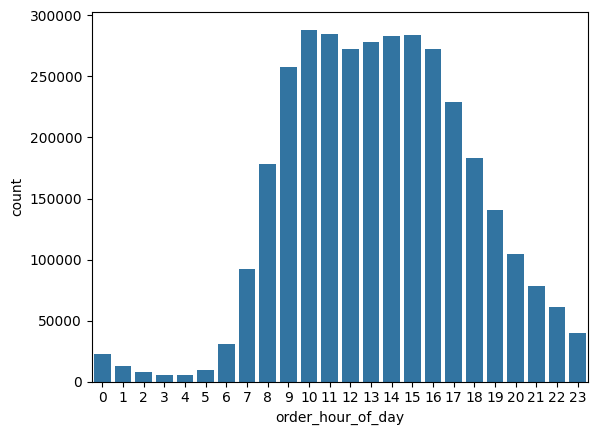

In [ ]:
sns.countplot(x='order_hour_of_day',data=orders)

The active hours are roughly between **7am-7pm**.

<Axes: xlabel='order_dow', ylabel='count'>

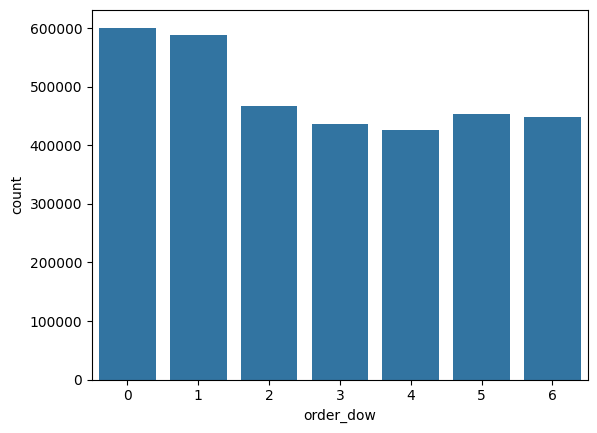

In [ ]:
sns.countplot(x='order_dow',data=orders)

Considering standard day of the week codes, there seems to be more orders **Monday & Tuesday**.

# Product Catlog Exploration

We will merge products, department, & aisles data to get whole picture about product catlog.

**Summary of observation:**
- **Personal care, snacks, pantry** are departments having lot of inventory.
- **Snacks, dairy/eggs, personal care** departments have some of the most populated aisles.
- **Fresh vegetables, fresh fruits, & packaged vegetales** fruits are most popular aisles over all.

In [ ]:
items = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


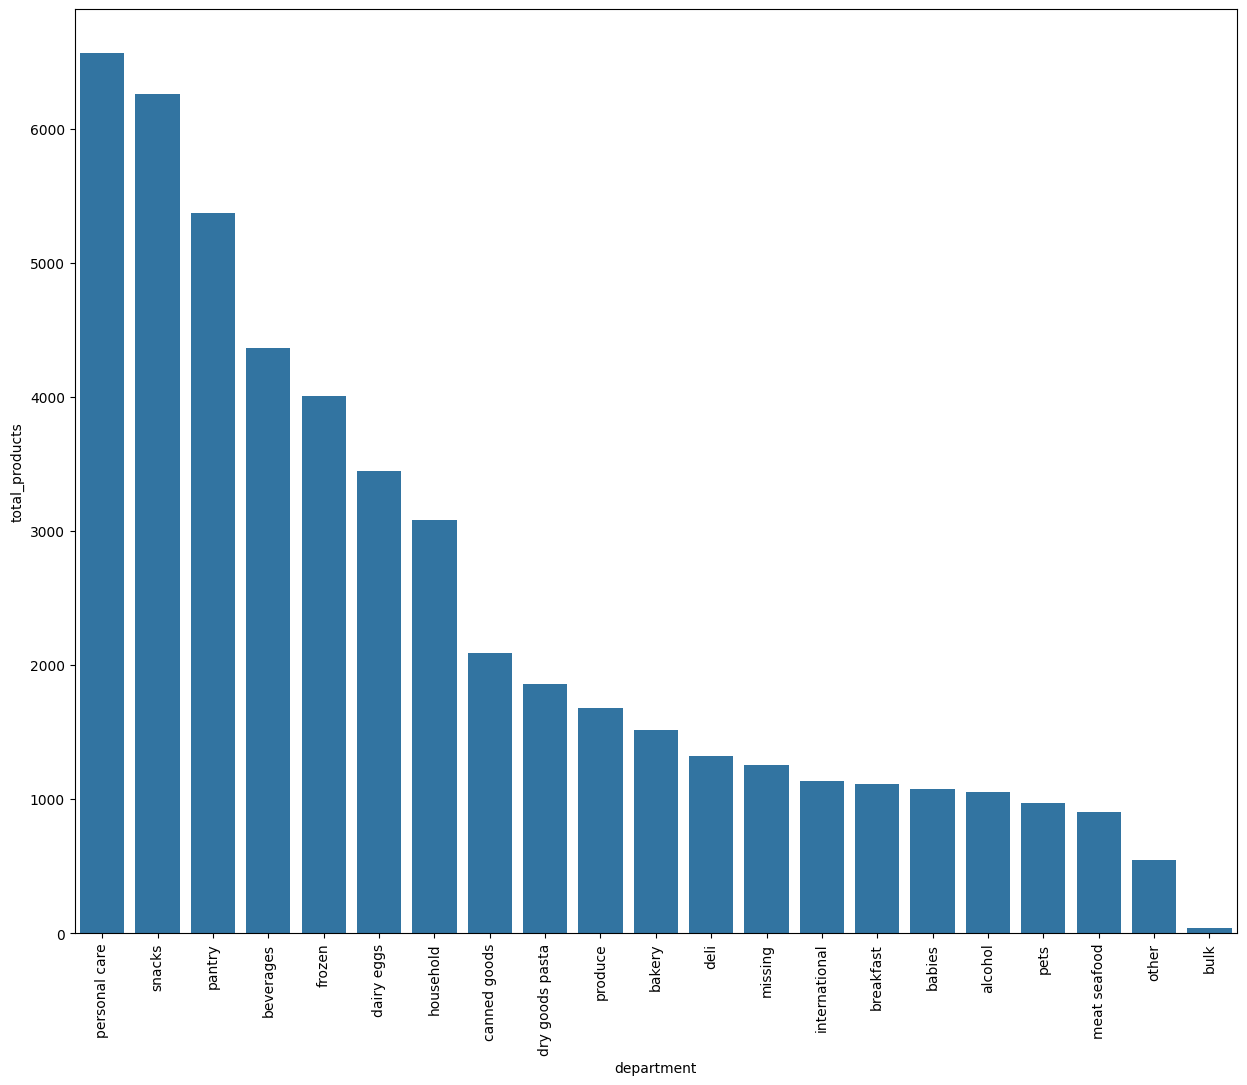

In [ ]:
df = items.groupby('department').agg(
    total_products = ('product_id','count')
).reset_index().sort_values(by='total_products',ascending=False)
df['ratio'] = df.total_products/df.total_products.sum()

plt.subplots(figsize=(15,12))
sns.barplot(x='department',y='total_products',data=df)
plt.xticks(rotation='vertical')
plt.show()

**Personal care, snacks, pantry** are departments having lot of inventory.

**The most dense aiseles in each Department(by number of proucts)**

In [ ]:
items.department.unique()

array(['snacks', 'pantry', 'beverages', 'frozen', 'personal care',
       'dairy eggs', 'household', 'babies', 'meat seafood',
       'dry goods pasta', 'pets', 'breakfast', 'canned goods', 'produce',
       'missing', 'international', 'deli', 'alcohol', 'bakery', 'other',
       'bulk'], dtype=object)

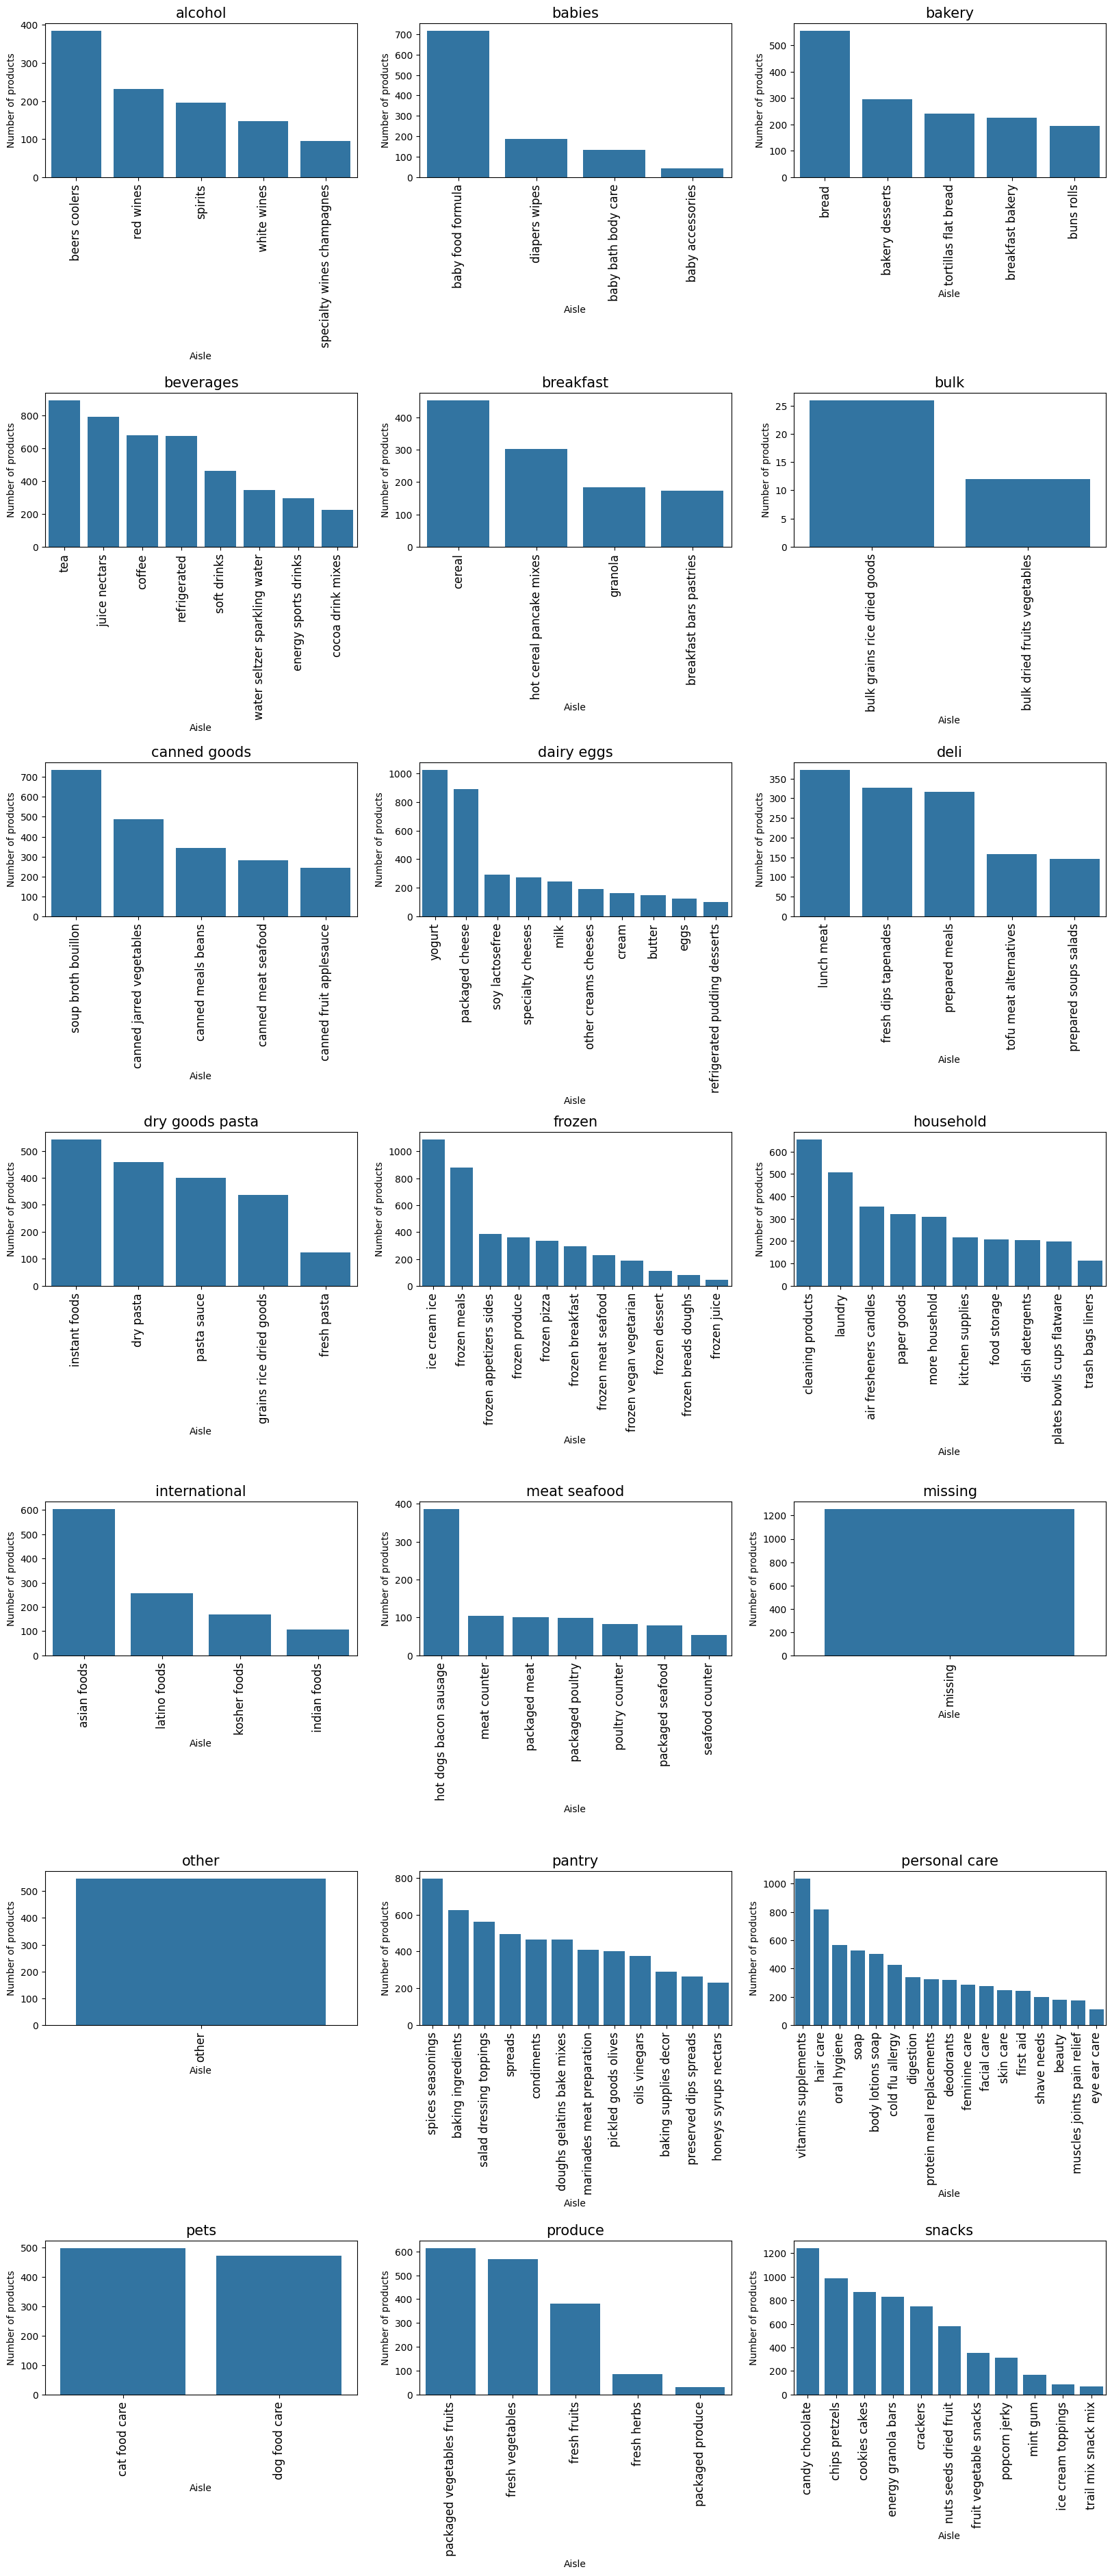

In [ ]:
df = items.groupby(['department','aisle']).agg(
    total_products = ('product_id','count')
).reset_index().sort_values(by='total_products',ascending=False)

fig, axes = plt.subplots(7,3, figsize=(20, 45), gridspec_kw=dict(hspace=1.4))
for (department, df), ax in zip(df.groupby('department'), axes.flatten()):
    g = sns.barplot(x=df.aisle,y=df.total_products,ax=ax)
    g.set(xlabel="Aisle", ylabel="Number of products")
    g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=12)
    ax.set_title(department, fontsize=15)
plt.tight_layout()
plt.show()

**Snacks, dairy/eggs, personal care** departments have some of the most populated aisles.

**Best Selling aisles over all departments**

In [ ]:
df=pd.merge(left=orders[['user_id', 'order_id']],right=order_products_train,on='order_id', how='inner')
df = df.merge(items[['product_id', 'aisle']], on='product_id', how='inner')
df.head()

,user_id,order_id,product_id,add_to_cart_order,reordered,aisle
0,1,1187899,196,1,1,soft drinks
1,1,1187899,25133,2,1,packaged cheese
2,1,1187899,38928,3,1,yogurt
3,1,1187899,26405,4,1,paper goods
4,1,1187899,39657,5,1,candy chocolate


In [ ]:
df1 = df.groupby('aisle').agg(
    total_orders = ('order_id','count')
).reset_index().sort_values(by='total_orders',ascending=False).head(10)
df1['ratio'] = df1.total_orders/df1.total_orders.sum()
df1.head()

,aisle,total_orders,ratio
53,fresh vegetables,150609,0.240237
50,fresh fruits,150473,0.240020
98,packaged vegetables fruits,78493,0.125204
133,yogurt,55240,0.088113
93,packaged cheese,41699,0.066514


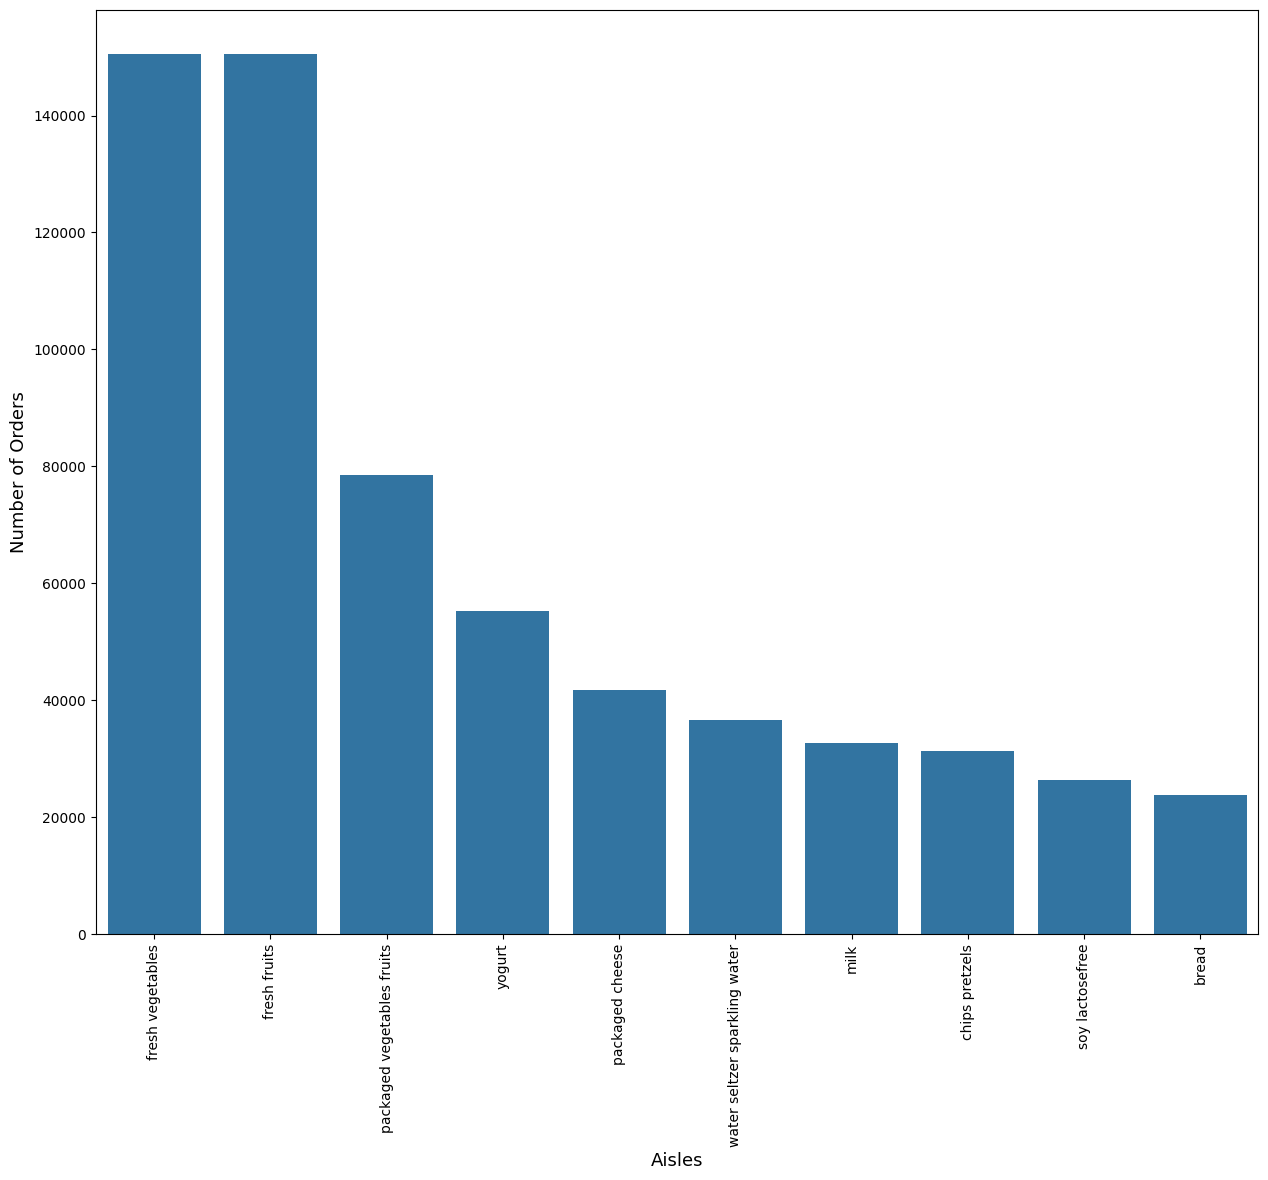

In [ ]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='vertical')
sns.barplot(x=df1.aisle, y=df1.total_orders, ax=ax)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

**Fresh vegetables, fresh fruits, & packaged vegetales** fruits are most popular aisles over all.

# The next steps
Now I will products data to find affinity of customers to aisles.

This relationship will help us segment customer behaviours. Doing this will provide insights to various departments to take decisions & drive profits.

**I will use customer & aisles association to build Principal Components & then use PC to train KNN calssifier.**